In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = conv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_3 = conv2DBatchNormRelu(
            32, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv = nn.Conv2d(64, 3, 3, stride = 1)
        self.flatten = nn.Flatten()     
        self.sigmoid = nn.Sigmoid()
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.maxpool2d(self.cbr_3(x))
        
        #全結合層
        x = self.flatten(self.global_avg(self.sigmoid(self.conv(x))))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─conv2DBatchNormRelu: 1-3               [64, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 32, 16, 16]          4,640
│    └─BatchNorm2d: 2-6                  [64, 32, 16, 16]          64
│    └─ReLU: 2-7                         [64, 32, 16, 16]          --
│    └─Dropout2d: 2-8                    [64, 32, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 32, 8, 8]            --
├─conv2DBat

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=200
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.66it/s]


val Loss: 1.0987 Acc: 0.2590
Epoch 2/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


train Loss: 1.0333 Acc: 0.4755


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 1.0357 Acc: 0.4810
Epoch 3/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.9505 Acc: 0.5736


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 1.0050 Acc: 0.4990
Epoch 4/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.9138 Acc: 0.6156


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.9153 Acc: 0.6295
Epoch 5/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.9146 Acc: 0.6276


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.8484 Acc: 0.7000
Epoch 6/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.8846 Acc: 0.6607


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.9004 Acc: 0.6476
Epoch 7/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


train Loss: 0.8789 Acc: 0.6657


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8817 Acc: 0.6529
Epoch 8/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.8639 Acc: 0.6707


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8490 Acc: 0.7005
Epoch 9/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


train Loss: 0.8676 Acc: 0.6727


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7838 Acc: 0.7705
Epoch 10/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.8523 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.32it/s]


val Loss: 0.7879 Acc: 0.7638
Epoch 11/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.8560 Acc: 0.6927


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.33it/s]


val Loss: 0.7775 Acc: 0.7805
Epoch 12/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8331 Acc: 0.7187


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.7745 Acc: 0.7805
Epoch 13/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.8374 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.7760 Acc: 0.7933
Epoch 14/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.8334 Acc: 0.7097


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.7966 Acc: 0.7519
Epoch 15/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.8279 Acc: 0.7097


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7982 Acc: 0.7624
Epoch 16/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8236 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.37it/s]


val Loss: 0.7857 Acc: 0.7657
Epoch 17/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.8149 Acc: 0.7347


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.7925 Acc: 0.7510
Epoch 18/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.8076 Acc: 0.7467


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.7903 Acc: 0.7600
Epoch 19/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.8096 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7740 Acc: 0.7824
Epoch 20/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.8134 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8086 Acc: 0.7343
Epoch 21/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.14it/s]


train Loss: 0.8061 Acc: 0.7377


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7693 Acc: 0.7786
Epoch 22/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.8024 Acc: 0.7477


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.8189 Acc: 0.7519
Epoch 23/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.7953 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.8061 Acc: 0.7386
Epoch 24/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.7938 Acc: 0.7608


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8526 Acc: 0.7019
Epoch 25/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.7733 Acc: 0.7758


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7649 Acc: 0.7919
Epoch 26/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


train Loss: 0.7844 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.7331 Acc: 0.8262
Epoch 27/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


train Loss: 0.7877 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7822 Acc: 0.7652
Epoch 28/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.7727 Acc: 0.7798


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7958 Acc: 0.7590
Epoch 29/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.7634 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7695 Acc: 0.7786
Epoch 30/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7660 Acc: 0.7878


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.32it/s]


val Loss: 0.8556 Acc: 0.6767
Epoch 31/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7637 Acc: 0.7878


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.8112 Acc: 0.7357
Epoch 32/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.7585 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7716 Acc: 0.7724
Epoch 33/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.7664 Acc: 0.7848


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.33it/s]


val Loss: 0.7990 Acc: 0.7486
Epoch 34/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.7455 Acc: 0.8288


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.36it/s]


val Loss: 0.7598 Acc: 0.7852
Epoch 35/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7707 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.7607 Acc: 0.7857
Epoch 36/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7471 Acc: 0.8178


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.42it/s]


val Loss: 0.7879 Acc: 0.7552
Epoch 37/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.7476 Acc: 0.8078


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.7443 Acc: 0.8095
Epoch 38/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7575 Acc: 0.7928


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.7786 Acc: 0.7729
Epoch 39/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.7470 Acc: 0.8048


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7573 Acc: 0.7910
Epoch 40/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


train Loss: 0.7616 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8021 Acc: 0.7429
Epoch 41/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.7506 Acc: 0.7968


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8102 Acc: 0.7352
Epoch 42/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.7409 Acc: 0.8148


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7590 Acc: 0.7881
Epoch 43/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.7460 Acc: 0.8088


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7973 Acc: 0.7571
Epoch 44/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


train Loss: 0.7398 Acc: 0.8128


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7529 Acc: 0.8010
Epoch 45/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


train Loss: 0.7365 Acc: 0.8228


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7760 Acc: 0.7671
Epoch 46/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.7308 Acc: 0.8218


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7709 Acc: 0.7771
Epoch 47/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


train Loss: 0.7248 Acc: 0.8348


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7363 Acc: 0.8186
Epoch 48/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.7258 Acc: 0.8258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7671 Acc: 0.7819
Epoch 49/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


train Loss: 0.7274 Acc: 0.8318


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7641 Acc: 0.7905
Epoch 50/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


train Loss: 0.7171 Acc: 0.8408


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8011 Acc: 0.7390
Epoch 51/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.7188 Acc: 0.8498


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7772 Acc: 0.7714
Epoch 52/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.7249 Acc: 0.8388


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7502 Acc: 0.7995
Epoch 53/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.7280 Acc: 0.8288


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7794 Acc: 0.7776
Epoch 54/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.7161 Acc: 0.8398


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7539 Acc: 0.7995
Epoch 55/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7124 Acc: 0.8408


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.7734 Acc: 0.7786
Epoch 56/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.7269 Acc: 0.8298


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.32it/s]


val Loss: 0.7459 Acc: 0.8033
Epoch 57/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7063 Acc: 0.8609


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7818 Acc: 0.7662
Epoch 58/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7148 Acc: 0.8529


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.38it/s]


val Loss: 0.7535 Acc: 0.7962
Epoch 59/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7111 Acc: 0.8418


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.7591 Acc: 0.7919
Epoch 60/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.7136 Acc: 0.8529


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7475 Acc: 0.8005
Epoch 61/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7081 Acc: 0.8498


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7376 Acc: 0.8100
Epoch 62/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7051 Acc: 0.8549


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.33it/s]


val Loss: 0.7312 Acc: 0.8248
Epoch 63/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.6960 Acc: 0.8679


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7512 Acc: 0.8010
Epoch 64/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.07it/s]


train Loss: 0.7104 Acc: 0.8478


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7243 Acc: 0.8271
Epoch 65/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.7042 Acc: 0.8569


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7449 Acc: 0.8052
Epoch 66/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.6915 Acc: 0.8739


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.01it/s]


val Loss: 0.7561 Acc: 0.7848
Epoch 67/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.7016 Acc: 0.8619


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.03it/s]


val Loss: 0.7686 Acc: 0.7748
Epoch 68/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.6980 Acc: 0.8599


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7685 Acc: 0.7843
Epoch 69/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


train Loss: 0.6943 Acc: 0.8669


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7592 Acc: 0.7957
Epoch 70/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.6830 Acc: 0.8769


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7617 Acc: 0.7871
Epoch 71/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


train Loss: 0.6929 Acc: 0.8649


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7665 Acc: 0.7852
Epoch 72/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


train Loss: 0.6979 Acc: 0.8649


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7966 Acc: 0.7538
Epoch 73/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


train Loss: 0.6962 Acc: 0.8669


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7401 Acc: 0.8129
Epoch 74/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.6922 Acc: 0.8649


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7688 Acc: 0.7833
Epoch 75/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.6904 Acc: 0.8679


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7493 Acc: 0.7967
Epoch 76/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.6830 Acc: 0.8839


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.8193 Acc: 0.7395
Epoch 77/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.6758 Acc: 0.8929


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7573 Acc: 0.7914
Epoch 78/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.6939 Acc: 0.8689


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7747 Acc: 0.7752
Epoch 79/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.6889 Acc: 0.8699


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7558 Acc: 0.7852
Epoch 80/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.6812 Acc: 0.8849


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7557 Acc: 0.7924
Epoch 81/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.6896 Acc: 0.8709


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.37it/s]


val Loss: 0.7724 Acc: 0.7752
Epoch 82/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.6687 Acc: 0.9019


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7400 Acc: 0.8162
Epoch 83/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.6910 Acc: 0.8649


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8246 Acc: 0.7200
Epoch 84/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.6777 Acc: 0.8849


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7278 Acc: 0.8252
Epoch 85/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.6746 Acc: 0.8889


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7742 Acc: 0.7757
Epoch 86/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.6818 Acc: 0.8849


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7541 Acc: 0.7933
Epoch 87/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.6758 Acc: 0.8919


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7287 Acc: 0.8176
Epoch 88/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.6793 Acc: 0.8849


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7816 Acc: 0.7648
Epoch 89/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.6730 Acc: 0.8879


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8187 Acc: 0.7167
Epoch 90/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


train Loss: 0.6706 Acc: 0.8949


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7862 Acc: 0.7576
Epoch 91/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


train Loss: 0.6684 Acc: 0.8969


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7773 Acc: 0.7676
Epoch 92/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.6607 Acc: 0.9109


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7892 Acc: 0.7633
Epoch 93/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


train Loss: 0.6748 Acc: 0.8919


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7620 Acc: 0.7881
Epoch 94/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.6734 Acc: 0.8859


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7556 Acc: 0.7938
Epoch 95/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.6720 Acc: 0.8939


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7349 Acc: 0.8157
Epoch 96/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.6658 Acc: 0.8969


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.8034 Acc: 0.7452
Epoch 97/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.6609 Acc: 0.8979


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7287 Acc: 0.8286
Epoch 98/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.6600 Acc: 0.9019


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7838 Acc: 0.7667
Epoch 99/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.6606 Acc: 0.9069


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7673 Acc: 0.7862
Epoch 100/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.6711 Acc: 0.8839


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7718 Acc: 0.7762
Epoch 101/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.6565 Acc: 0.9049


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7774 Acc: 0.7690
Epoch 102/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.6600 Acc: 0.9069


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.7299 Acc: 0.8329
Epoch 103/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.6543 Acc: 0.9039


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.7704 Acc: 0.7762
Epoch 104/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.6605 Acc: 0.9089


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7645 Acc: 0.7843
Epoch 105/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.6490 Acc: 0.9179


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.8065 Acc: 0.7314
Epoch 106/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.6505 Acc: 0.9189


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7640 Acc: 0.7848
Epoch 107/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.6540 Acc: 0.9129


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7348 Acc: 0.8162
Epoch 108/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.6589 Acc: 0.8999


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7475 Acc: 0.7971
Epoch 109/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.6553 Acc: 0.9099


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7445 Acc: 0.8100
Epoch 110/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.6623 Acc: 0.8919


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7724 Acc: 0.7800
Epoch 111/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.6488 Acc: 0.9209


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7377 Acc: 0.8190
Epoch 112/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


train Loss: 0.6507 Acc: 0.9149


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7261 Acc: 0.8243
Epoch 113/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


train Loss: 0.6598 Acc: 0.9069


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7926 Acc: 0.7514
Epoch 114/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


train Loss: 0.6547 Acc: 0.9049


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7537 Acc: 0.7981
Epoch 115/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.6489 Acc: 0.9179


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7287 Acc: 0.8286
Epoch 116/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.6485 Acc: 0.9179


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8325 Acc: 0.6995
Epoch 117/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.6405 Acc: 0.9259


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.8637 Acc: 0.6671
Epoch 118/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.6509 Acc: 0.9159


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7425 Acc: 0.8133
Epoch 119/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


train Loss: 0.6435 Acc: 0.9199


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7730 Acc: 0.7771
Epoch 120/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.6527 Acc: 0.9049


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7502 Acc: 0.7938
Epoch 121/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.6442 Acc: 0.9249


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7676 Acc: 0.7862
Epoch 122/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.6454 Acc: 0.9269


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.7437 Acc: 0.8100
Epoch 123/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.6457 Acc: 0.9209


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7537 Acc: 0.7952
Epoch 124/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.6458 Acc: 0.9119


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.7774 Acc: 0.7657
Epoch 125/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.6430 Acc: 0.9209


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.7883 Acc: 0.7590
Epoch 126/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.6449 Acc: 0.9179


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.7455 Acc: 0.8033
Epoch 127/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.6313 Acc: 0.9339


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.7504 Acc: 0.7938
Epoch 128/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.6413 Acc: 0.9279


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.32it/s]


val Loss: 0.7208 Acc: 0.8352
Epoch 129/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.6403 Acc: 0.9339


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7678 Acc: 0.7771
Epoch 130/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.6441 Acc: 0.9229


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7314 Acc: 0.8205
Epoch 131/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.6352 Acc: 0.9269


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7472 Acc: 0.8024
Epoch 132/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.6344 Acc: 0.9319


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7410 Acc: 0.8076
Epoch 133/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.6405 Acc: 0.9219


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7462 Acc: 0.8005
Epoch 134/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.14it/s]


train Loss: 0.6329 Acc: 0.9399


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7452 Acc: 0.8052
Epoch 135/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.6356 Acc: 0.9339


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7244 Acc: 0.8233
Epoch 136/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.6342 Acc: 0.9399


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7283 Acc: 0.8233
Epoch 137/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


train Loss: 0.6309 Acc: 0.9359


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.7418 Acc: 0.8029
Epoch 138/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


train Loss: 0.6238 Acc: 0.9359


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7521 Acc: 0.8043
Epoch 139/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.6283 Acc: 0.9369


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7639 Acc: 0.7852
Epoch 140/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.6353 Acc: 0.9349


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7360 Acc: 0.8095
Epoch 141/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


train Loss: 0.6246 Acc: 0.9379


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7485 Acc: 0.8010
Epoch 142/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.6177 Acc: 0.9499


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7519 Acc: 0.7986
Epoch 143/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


train Loss: 0.6339 Acc: 0.9199


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7496 Acc: 0.7986
Epoch 144/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.6308 Acc: 0.9349


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7493 Acc: 0.7919
Epoch 145/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.6247 Acc: 0.9389


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7815 Acc: 0.7700
Epoch 146/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.6226 Acc: 0.9479


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7537 Acc: 0.7871
Epoch 147/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.6217 Acc: 0.9499


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7365 Acc: 0.8100
Epoch 148/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.6344 Acc: 0.9359


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7704 Acc: 0.7743
Epoch 149/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.6264 Acc: 0.9459


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7436 Acc: 0.8033
Epoch 150/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.6216 Acc: 0.9459


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.32it/s]


val Loss: 0.7688 Acc: 0.7752
Epoch 151/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.6220 Acc: 0.9389


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.33it/s]


val Loss: 0.7615 Acc: 0.7871
Epoch 152/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.6252 Acc: 0.9439


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7457 Acc: 0.8067
Epoch 153/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.6269 Acc: 0.9359


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.32it/s]


val Loss: 0.7813 Acc: 0.7657
Epoch 154/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.6267 Acc: 0.9399


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7358 Acc: 0.8171
Epoch 155/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.6223 Acc: 0.9429


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7745 Acc: 0.7667
Epoch 156/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.6302 Acc: 0.9359


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7658 Acc: 0.7848
Epoch 157/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.6181 Acc: 0.9489


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7410 Acc: 0.8100
Epoch 158/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.6229 Acc: 0.9510


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7826 Acc: 0.7719
Epoch 159/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.6224 Acc: 0.9469


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7447 Acc: 0.7967
Epoch 160/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.6210 Acc: 0.9439


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7781 Acc: 0.7681
Epoch 161/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.6204 Acc: 0.9399


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7668 Acc: 0.7829
Epoch 162/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.6104 Acc: 0.9600


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7552 Acc: 0.7962
Epoch 163/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.6124 Acc: 0.9620


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7498 Acc: 0.8038
Epoch 164/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.6297 Acc: 0.9369


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7465 Acc: 0.7995
Epoch 165/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


train Loss: 0.6125 Acc: 0.9590


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7934 Acc: 0.7500
Epoch 166/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.6198 Acc: 0.9449


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7538 Acc: 0.7924
Epoch 167/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.6176 Acc: 0.9469


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7530 Acc: 0.7986
Epoch 168/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.6197 Acc: 0.9530


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7518 Acc: 0.7938
Epoch 169/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


train Loss: 0.6118 Acc: 0.9560


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7732 Acc: 0.7686
Epoch 170/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.6206 Acc: 0.9419


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7678 Acc: 0.7752
Epoch 171/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.6142 Acc: 0.9469


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.7550 Acc: 0.7933
Epoch 172/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.6104 Acc: 0.9620


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7433 Acc: 0.8071
Epoch 173/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.6123 Acc: 0.9630


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7763 Acc: 0.7657
Epoch 174/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.6129 Acc: 0.9560


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7482 Acc: 0.7981
Epoch 175/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.6161 Acc: 0.9540


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7843 Acc: 0.7562
Epoch 176/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.6134 Acc: 0.9550


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.33it/s]


val Loss: 0.7404 Acc: 0.8090
Epoch 177/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6138 Acc: 0.9510


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7511 Acc: 0.7933
Epoch 178/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.6084 Acc: 0.9590


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7442 Acc: 0.8081
Epoch 179/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.6166 Acc: 0.9489


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7465 Acc: 0.8005
Epoch 180/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.6110 Acc: 0.9530


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7655 Acc: 0.7771
Epoch 181/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.6080 Acc: 0.9570


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7457 Acc: 0.8062
Epoch 182/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.6113 Acc: 0.9520


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.7441 Acc: 0.8062
Epoch 183/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.6083 Acc: 0.9620


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7388 Acc: 0.8157
Epoch 184/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.6159 Acc: 0.9560


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7561 Acc: 0.7910
Epoch 185/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.6057 Acc: 0.9600


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7642 Acc: 0.7819
Epoch 186/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


train Loss: 0.6052 Acc: 0.9660


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7370 Acc: 0.8129
Epoch 187/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.6079 Acc: 0.9590


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7831 Acc: 0.7633
Epoch 188/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.6039 Acc: 0.9650


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.10it/s]


val Loss: 0.7783 Acc: 0.7681
Epoch 189/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


train Loss: 0.6096 Acc: 0.9570


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7348 Acc: 0.8129
Epoch 190/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


train Loss: 0.6155 Acc: 0.9520


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7429 Acc: 0.8095
Epoch 191/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


train Loss: 0.6014 Acc: 0.9660


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7721 Acc: 0.7771
Epoch 192/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


train Loss: 0.6003 Acc: 0.9640


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7476 Acc: 0.8038
Epoch 193/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


train Loss: 0.6081 Acc: 0.9580


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7369 Acc: 0.8143
Epoch 194/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.6049 Acc: 0.9620


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7576 Acc: 0.7962
Epoch 195/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.5984 Acc: 0.9730


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7602 Acc: 0.7862
Epoch 196/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.6041 Acc: 0.9650


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7536 Acc: 0.7995
Epoch 197/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.07it/s]


train Loss: 0.6042 Acc: 0.9650


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.10it/s]


val Loss: 0.7481 Acc: 0.8038
Epoch 198/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.6068 Acc: 0.9590


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7289 Acc: 0.8214
Epoch 199/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.6095 Acc: 0.9540


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7596 Acc: 0.7924
Epoch 200/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.6033 Acc: 0.9640


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.05it/s]

val Loss: 0.7605 Acc: 0.7848


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

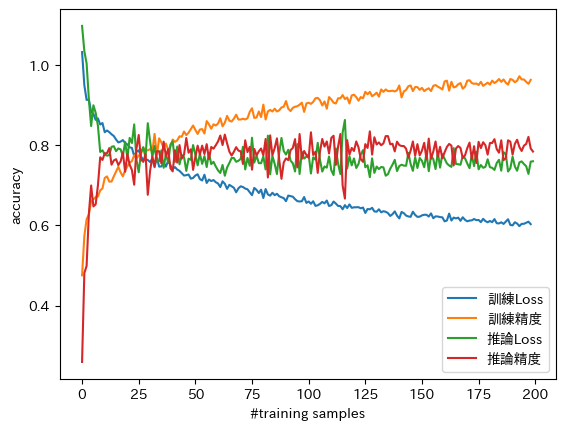

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

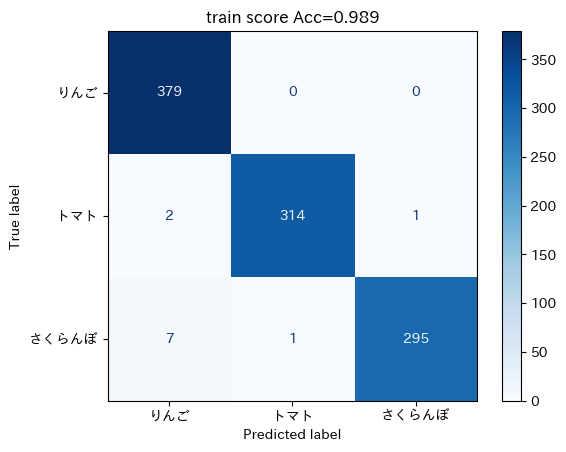

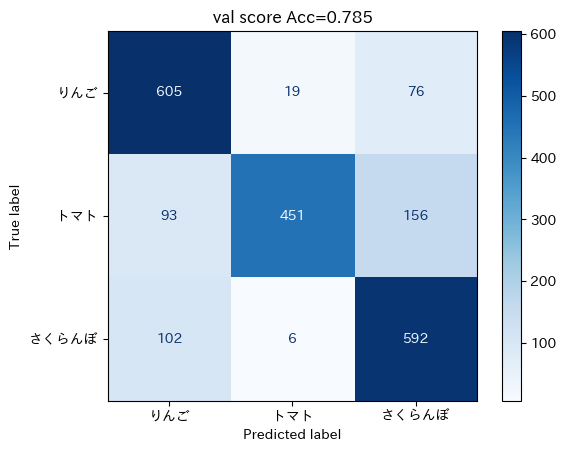

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

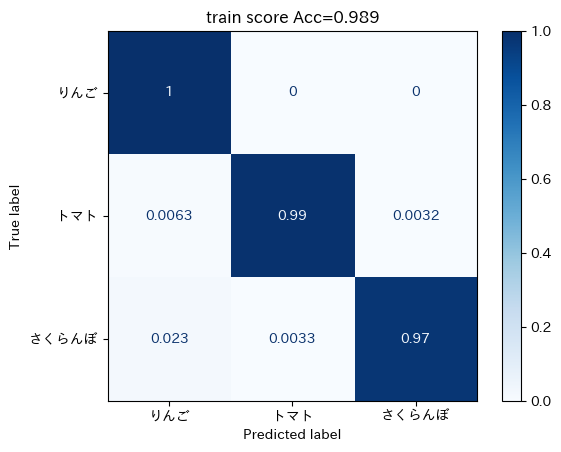

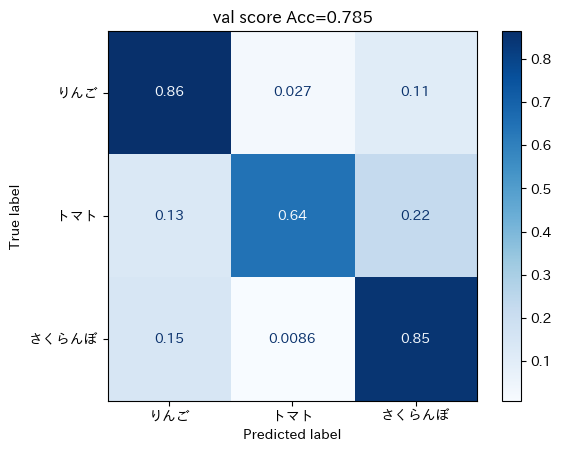

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()